In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import dynamic_range_nms
from utils.set_seed import seed_base

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ensemble"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ensemble']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-22 17:01:28.713017: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 17:01:28.780365: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-22 17:01:29.256974: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_ensemble


In [2]:
oof_df = pd.read_parquet(f'/kaggle/output/{CFG["patch_transformer_gru"]["execution"]["best_exp_id"]}/oof.parquet')
oof_df.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.004654,0.000332
1,05e1944c3818,18,0.003008,0.000308
2,05e1944c3818,30,0.002308,0.000296
3,05e1944c3818,42,0.001987,0.000282
4,05e1944c3818,54,0.001864,0.000265


In [3]:
dfs = []
for sid, df in tqdm(oof_df.groupby("series_id")):
    step_df = pd.read_parquet(f"{CFG['dataset']['step_csv_dir']}/{sid}.parquet")
    df = df.merge(step_df[["step", "day", "wakeup_target", "onset_target"]], on="step", how="right")

    day_df = pd.concat([
        df.groupby("day")[["wakeup_oof", "onset_oof"]].sum(),
        (df.groupby("day")["wakeup_target"].max() > 0).rename("have_target"),
    ], axis=1)
    dfs.append(day_df)

100%|██████████| 277/277 [00:40<00:00,  6.89it/s]


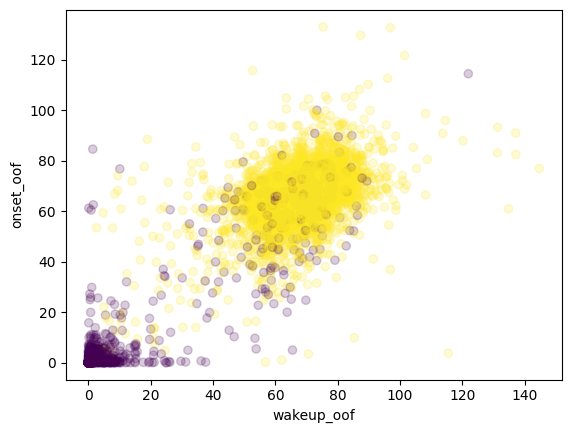

In [4]:
import matplotlib.pyplot as plt

df = pd.concat(dfs).reset_index()
plt.scatter(df["wakeup_oof"], df["onset_oof"], alpha=0.2, c=df["have_target"])
plt.xlabel("wakeup_oof")
plt.ylabel("onset_oof")
plt.show()

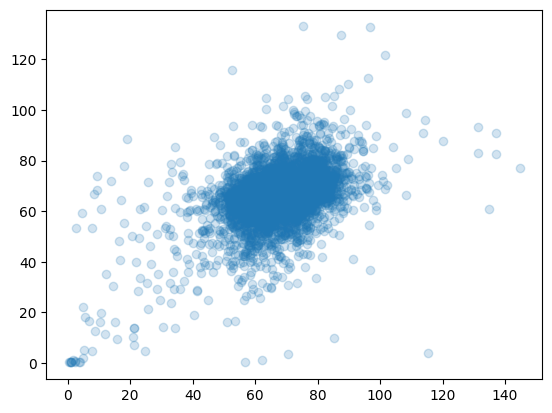

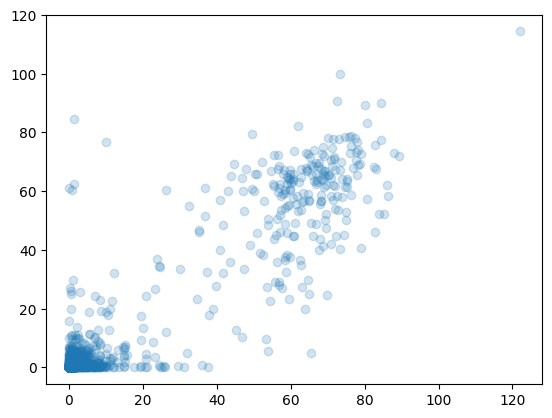

In [5]:
plt.scatter(df[df["have_target"]]["wakeup_oof"], df[df["have_target"]]["onset_oof"], alpha=0.2)
plt.show()
plt.scatter(df[~df["have_target"]]["wakeup_oof"], df[~df["have_target"]]["onset_oof"], alpha=0.2)
plt.show()

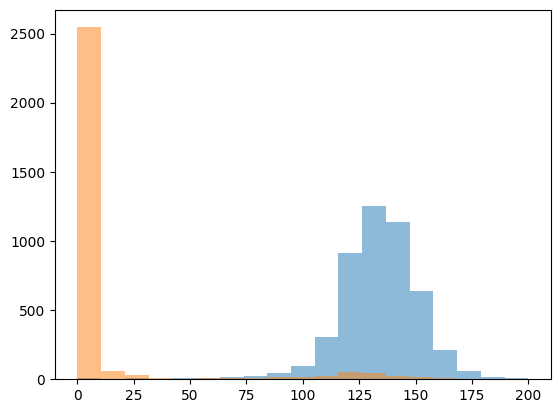

In [6]:
import numpy as np

df["pred_sum"] = df["wakeup_oof"] + df["onset_oof"]
plt.hist(df[df["have_target"]]["pred_sum"], bins=np.linspace(0, 200, 20), alpha=0.5)
plt.hist(df[~df["have_target"]]["pred_sum"], bins=np.linspace(0, 200, 20), alpha=0.5) 
plt.show()

maybe days whose pred_sum is lower than 50 tend to miss target?

---

In [7]:
threshold = 50

dfs = []
for sid, df in tqdm(oof_df.groupby("series_id")):
    step_df = pd.read_parquet(f"{CFG['dataset']['step_csv_dir']}/{sid}.parquet")
    df = df.merge(step_df[["step", "day"]], on="step", how="right")
    
    pred_sum = df.groupby("day")[["wakeup_oof", "onset_oof"]].sum().sum(axis=1)
    df["pred_sum"] = df["day"].map(pred_sum)
    df = df[df["pred_sum"] > threshold]
    dfs.append(df)
oof_df = pd.concat(dfs).reset_index(drop=True)

100%|██████████| 277/277 [00:40<00:00,  6.86it/s]


2691748

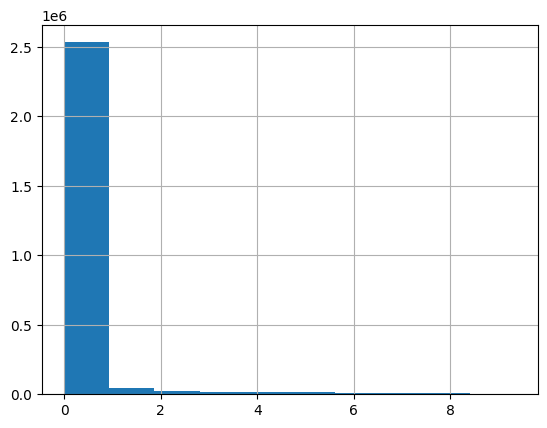

In [8]:
dfs = []
df = oof_df[["series_id", "step", "wakeup_oof"]]
df = df[df["wakeup_oof"] > 0.001]
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = oof_df[["series_id", "step", "onset_oof"]]
df = df[df["onset_oof"] > 0.001]
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs).reset_index(drop=True)
train["step"] = train["step"].astype(int)
train["score"].hist()
len(train)

In [9]:
from multiprocessing import Pool

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 266/266 [00:07<00:00, 36.29it/s]


In [10]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
labels = labels[labels["series_id"].isin(sub["series_id"].unique())]
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

score: 0.8064


event   tolerance
onset   12           0.409250
        36           0.720212
        60           0.793543
        90           0.830751
        120          0.857408
        150          0.867867
        180          0.881087
        240          0.891902
        300          0.898200
        360          0.904828
wakeup  12           0.441970
        36           0.726678
        60           0.799724
        90           0.825191
        120          0.849197
        150          0.860519
        180          0.873491
        240          0.887945
        300          0.900086
        360          0.908339
dtype: float64

---